# Introduction

#### A new wholesale business will be established in New York. The business will particularly target other businesses that have many employees in offices, and also restaurants, coffee shops where people are expected to eat their meals and use single-use disposable utensils. 
#### The client is looking for the most suitable location that will be located close to potential customers and be able to deliver ordered products with same day delivery service option.

# Data / Methods

#### Data will be mainly scraped via Foursquare API location data from the city of New York. Scrape data will include but not limited to, longitude, latitude of neighborhoods, zip codes, business names, business types. 
#### Data will be used to explore businesses, cluster and rank neighborhoods which may have a high potential customers such as restaurants, cafes, bars, bakeries and etc.  


In [2]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim 
import requests
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
#import k-means from clustering stage
from sklearn.cluster import KMeans
import folium 
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0



geopy-1.21.0         | 58 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Lib

In [3]:
CLIENT_ID = 'WGVL5T4E4XBGSQTPLT0I2VRTB1PII50GZAJ0VRYBBX4OJH0F' # your Foursquare ID
CLIENT_SECRET = 'IW3QHFFO5AI1ZF5GQND3UKXG555SSNYQFHSMQM5DC3QUZKMU' # your Foursquare Secret
VERSION = '20180605'

In [4]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    

In [5]:
neighborhoods_data = newyork_data['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [6]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [8]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
loc_data = neighborhoods[neighborhoods['Borough'] == 'loc'].reset_index(drop=True)
loc_data.head()

,Borough,Neighborhood,Latitude,Longitude


In [193]:
neighborhood_latitude = neighborhoods.loc[:,'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[:,'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name


In [194]:
LIMIT = 100
radius = 500
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [195]:
#Commented out not to run foursqure, inqury saves as CSV file down below. 

# neighborhood_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
#                                    latitudes=neighborhoods['Latitude'],
#                                    longitudes=neighborhoods['Longitude']
#                                   )



# Downloaded foursquare data

In [10]:
neighborhood_venues = pd.read_csv("neighborhood_venue.csv")
neighborhood_venues.head()

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


# Write a local CSV file for neighborhood_venues - to avoid foursquare query each time


In [11]:
#neighborhood_venues.to_csv("neighborhood_venue.csv")

In [12]:
print(neighborhood_venues.shape)

(10046, 8)


In [13]:
print('There are {} uniques categories.'.format(len(neighborhood_venues['Venue Category'].unique())))

There are 424 uniques categories.


# Let's check Unique Venue Categories and sort them

In [15]:
neighborhood_venues.groupby('Venue Category').count().sort_values(by=["Neighborhood"],ascending=False)

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,,
Pizza Place,443,443,443,443,443,443,443
Coffee Shop,313,313,313,313,313,313,313
Italian Restaurant,306,306,306,306,306,306,306
Deli / Bodega,266,266,266,266,266,266,266
Bar,232,232,232,232,232,232,232
Bakery,223,223,223,223,223,223,223
Chinese Restaurant,215,215,215,215,215,215,215
Grocery Store,195,195,195,195,195,195,195
Sandwich Place,190,190,190,190,190,190,190


# Lets focus on most common venues that are related to food serving
# Namely, we will use restaurants, coffee shop, bakery, deli, Café, bar and create a new dataframe

In [16]:
# food_venues = neighborhood_venues.loc[(neighborhood_venues['Venue Category'] == "Restaurant") |
#                                       (neighborhood_venues['Venue Category'] == "Coffee Shop") | 
#                                      (neighborhood_venues['Venue Category'] == "Bakery") |
#                                      (neighborhood_venues['Venue Category'] == "Café") ]


In [17]:
# A better way of filtering 
food_venues = neighborhood_venues[neighborhood_venues["Venue Category"].str.contains('Restaur')|
                        neighborhood_venues["Venue Category"].str.contains('Café')|
                        neighborhood_venues["Venue Category"].str.contains('Coffee')|
                        neighborhood_venues["Venue Category"].str.contains('Bakery')|
                        neighborhood_venues["Venue Category"].str.contains('Deli')|
                        neighborhood_venues["Venue Category"].str.contains('Bar') ]

In [18]:
food_venues.head()


,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
6,6,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant
16,16,Co-op City,40.874294,-73.829939,Arby's,40.870411,-73.828606,Fast Food Restaurant
17,17,Co-op City,40.874294,-73.829939,Townhouse Restaurant,40.876086,-73.828868,Restaurant
19,19,Co-op City,40.874294,-73.829939,Guang Hui Chinese Restaurant,40.876651,-73.829092,Chinese Restaurant
27,27,Eastchester,40.887556,-73.827806,Fish & Ting,40.885656,-73.829197,Caribbean Restaurant


# Total # of food business venues for each neighborhood

In [19]:
food_venues.groupby('Neighborhood').count()


,Unnamed: 0,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
Allerton,7,7,7,7,7,7,7
Annadale,4,4,4,4,4,4,4
Arden Heights,1,1,1,1,1,1,1
Arlington,2,2,2,2,2,2,2
Arrochar,7,7,7,7,7,7,7
Arverne,2,2,2,2,2,2,2
Astoria,61,61,61,61,61,61,61
Astoria Heights,5,5,5,5,5,5,5
Auburndale,8,8,8,8,8,8,8


In [20]:
venues_onehot = pd.get_dummies(food_venues[['Venue Category']], prefix="", prefix_sep="")
venues_onehot['Neighborhood'] = food_venues['Neighborhood'] 
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]
venues_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Bakery,Bar,Beach Bar,Beer Bar,Brazilian Restaurant,Burmese Restaurant,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Czech Restaurant,Deli / Bodega,Dim Sum Restaurant,Dive Bar,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Gay Bar,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hookah Bar,Hotel Bar,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pet Café,Piano Bar,Polish Restaurant,Ramen Restaurant,Restaurant,Romanian Restaurant,Russian Restaurant,Sake Bar,Salon / Barbershop,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sports Bar,Sri Lankan Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Tiki Bar,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yemeni Restaurant
6,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16,Co-op City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,Co-op City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19,Co-op City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27,Eastchester,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Group neighborhoods by taking the sum of occurrence of each venue

In [21]:
venues_grouped = venues_onehot.groupby('Neighborhood').sum().reset_index()
venues_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Bakery,Bar,Beach Bar,Beer Bar,Brazilian Restaurant,Burmese Restaurant,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Czech Restaurant,Deli / Bodega,Dim Sum Restaurant,Dive Bar,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Gay Bar,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hookah Bar,Hotel Bar,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pet Café,Piano Bar,Polish Restaurant,Ramen Restaurant,Restaurant,Romanian Restaurant,Russian Restaurant,Sake Bar,Salon / Barbershop,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sports Bar,Sri Lankan Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Tiki Bar,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yemeni Restaurant
0,Allerton,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Annadale,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Arden Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Arlington,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Arrochar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Sum all different restaurants under singe column per neighborhood

In [22]:
rest_list = [col for col in venues_grouped.columns if "Rest" in col]
venues_grouped['Rest_Total'] = venues_grouped[rest_list].sum(axis=1)
venues_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Bakery,Bar,Beach Bar,Beer Bar,Brazilian Restaurant,Burmese Restaurant,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Czech Restaurant,Deli / Bodega,Dim Sum Restaurant,Dive Bar,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Gay Bar,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hookah Bar,Hotel Bar,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,North Indian Restaurant,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pet Café,Piano Bar,Polish Restaurant,Ramen Restaurant,Restaurant,Romanian Restaurant,Russian Restaurant,Sake Bar,Salon / Barbershop,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sports Bar,Sri Lankan Restaurant,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Tiki Bar,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yemeni Restaurant,Rest_Total
0,Allerton,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
1,Annadale,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
2,Arden Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Arlington,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,Arrochar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5


# Drop all restaurant coloumn names except Rest_Total

In [23]:
venues_grouped = venues_grouped[["Neighborhood","Rest_Total", "Bakery", "Bar", "Café" ,"Coffee Shop", "Deli / Bodega"]]
venues_grouped.head()

,Neighborhood,Rest_Total,Bakery,Bar,Café,Coffee Shop,Deli / Bodega
0,Allerton,4,1,0,0,0,2
1,Annadale,2,0,0,0,0,1
2,Arden Heights,0,0,0,0,1,0
3,Arlington,1,0,0,0,0,1
4,Arrochar,5,0,0,0,0,2


# Rename coloumns for easier access

In [24]:
venues_grouped = venues_grouped.rename(columns={"Deli / Bodega" : "Deli","Café":"Cafe", "Coffee Shop":"CShop"})
venues_grouped.head()

,Neighborhood,Rest_Total,Bakery,Bar,Cafe,CShop,Deli
0,Allerton,4,1,0,0,0,2
1,Annadale,2,0,0,0,0,1
2,Arden Heights,0,0,0,0,1,0
3,Arlington,1,0,0,0,0,1
4,Arrochar,5,0,0,0,0,2


# EDA Statistics of Food Business in New York

In [25]:
print("Total Restaurant Business in New York")
venues_grouped["Rest_Total"].sum()

Total Restaurant Business in New York


2507

In [26]:
print("Total Bakery Business in New York")
venues_grouped["Bakery"].sum()

Total Bakery Business in New York


223

In [27]:
print("Total Bar Business in New York")
venues_grouped["Bar"].sum()

Total Bar Business in New York


232

In [28]:
print("Total Cafe Business in New York")
venues_grouped["Cafe"].sum()

Total Cafe Business in New York


180

In [29]:
print("Total Coffee Shop Business in New York")
venues_grouped["CShop"].sum()

Total Coffee Shop Business in New York


313

In [30]:
print("Total Deli Business in New York")
venues_grouped["Deli"].sum()

Total Deli Business in New York


266

# Most Common Food Businesses for each neighborhood

In [31]:
num_top_venues = 6

for hood in venues_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = venues_grouped[venues_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','total']
    temp = temp.iloc[1:]
    temp['total'] = temp['total'].astype(int)
    temp = temp.round({'total': 2})
    print(temp.sort_values('total', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allerton----
        venue  total
0  Rest_Total      4
1        Deli      2
2      Bakery      1
3         Bar      0
4        Cafe      0
5       CShop      0


----Annadale----
        venue  total
0  Rest_Total      2
1        Deli      1
2      Bakery      0
3         Bar      0
4        Cafe      0
5       CShop      0


----Arden Heights----
        venue  total
0       CShop      1
1  Rest_Total      0
2      Bakery      0
3         Bar      0
4        Cafe      0
5        Deli      0


----Arlington----
        venue  total
0  Rest_Total      1
1        Deli      1
2      Bakery      0
3         Bar      0
4        Cafe      0
5       CShop      0


----Arrochar----
        venue  total
0  Rest_Total      5
1        Deli      2
2      Bakery      0
3         Bar      0
4        Cafe      0
5       CShop      0


----Arverne----
        venue  total
0  Rest_Total      1
1       CShop      1
2      Bakery      0
3         Bar      0
4        Cafe      0
5        Deli      0



In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = venues_grouped['Neighborhood']

for ind in np.arange(venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.tail()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
274,Woodhaven,Rest_Total,Deli,CShop,Cafe,Bar
275,Woodlawn,Deli,Bar,Rest_Total,CShop,Cafe
276,Woodrow,Rest_Total,CShop,Bakery,Deli,Cafe
277,Woodside,Rest_Total,Bar,Bakery,Deli,CShop
278,Yorkville,Rest_Total,CShop,Bar,Deli,Cafe


# Clustering Neighborhoods

In [34]:
kclusters = 3
venues_grouped_clustering = venues_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venues_grouped_clustering)
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 2], dtype=int32)

In [35]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
loc_merged = neighborhoods
loc_merged = loc_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
loc_merged = loc_merged.dropna()
loc_merged["Cluster Labels"] = loc_merged["Cluster Labels"].astype(int)
loc_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,0,Rest_Total,Deli,CShop,Cafe,Bar
1,Bronx,Co-op City,40.874294,-73.829939,0,Rest_Total,Deli,CShop,Cafe,Bar
2,Bronx,Eastchester,40.887556,-73.827806,0,Rest_Total,Deli,CShop,Cafe,Bar
5,Bronx,Kingsbridge,40.881687,-73.902818,2,Rest_Total,Bar,Bakery,Deli,CShop
6,Manhattan,Marble Hill,40.876551,-73.910660,0,CShop,Rest_Total,Deli,Cafe,Bar


In [36]:
restaurants = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(loc_merged['Latitude'], loc_merged['Longitude'], loc_merged['Neighborhood'], loc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(restaurants)
       
restaurants

# Placing JPG map since folium map is not visible on Github

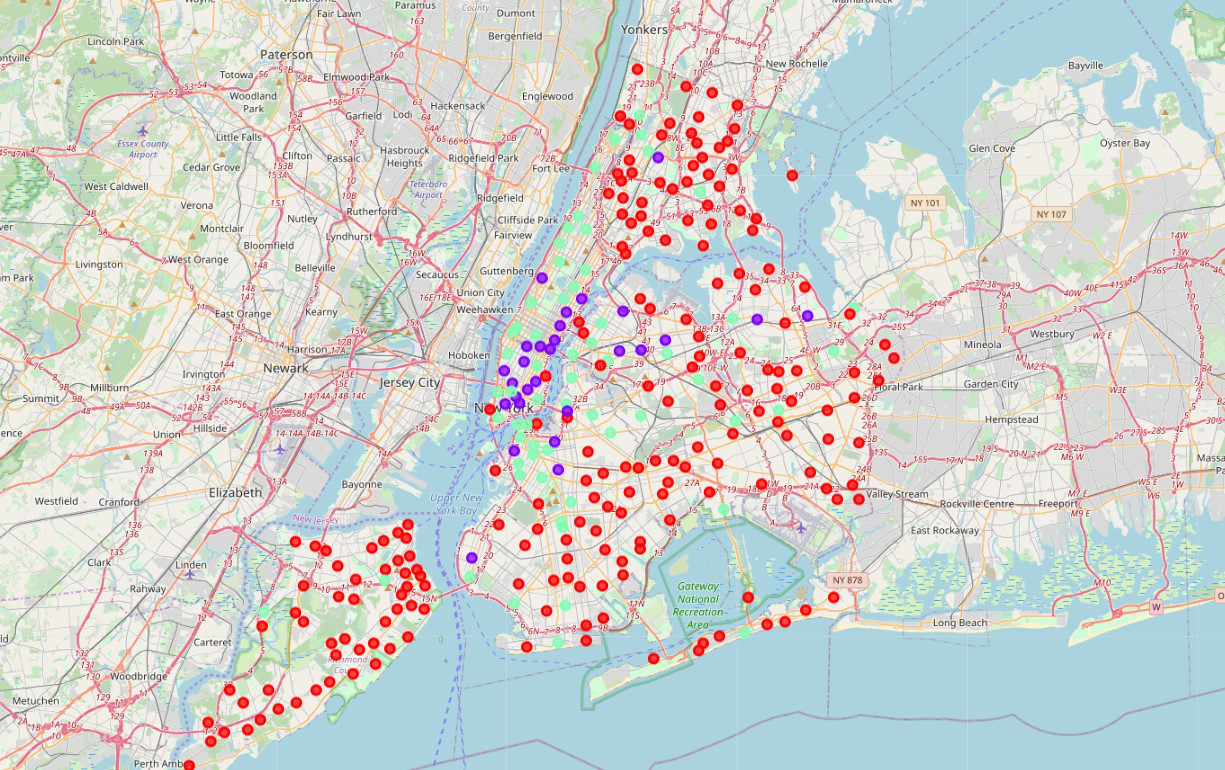

In [39]:
from PIL import Image
image = Image.open('flmap.jpg')
image

In [224]:
cluster1 = loc_merged.loc[loc_merged['Cluster Labels'] == 0, loc_merged.columns[[1] + list(range(5, loc_merged.shape[1]))]]
cluster1.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Wakefield,Rest_Total,Deli,CShop,Cafe,Bar
1,Co-op City,Rest_Total,Deli,CShop,Cafe,Bar
2,Eastchester,Rest_Total,Deli,CShop,Cafe,Bar
6,Marble Hill,CShop,Rest_Total,Deli,Cafe,Bar
7,Woodlawn,Deli,Bar,Rest_Total,CShop,Cafe


In [238]:
cluster1['2nd Most Common Venue'].value_counts()

Deli          119
Rest_Total     21
CShop          18
Bar            16
Bakery         14
Cafe            7
Name: 2nd Most Common Venue, dtype: int64

In [239]:
cluster2 = loc_merged.loc[loc_merged['Cluster Labels'] == 1, loc_merged.columns[[1] + list(range(5, loc_merged.shape[1]))]]
cluster2.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
34,Belmont,Rest_Total,Deli,Bakery,CShop,Bar
46,Bay Ridge,Rest_Total,Bar,CShop,Cafe,Deli
59,Prospect Heights,Rest_Total,Bar,Cafe,Bakery,Deli
65,Cobble Hill,Rest_Total,CShop,Bar,Deli,Bakery
84,Clinton Hill,Rest_Total,Deli,Cafe,Bar,CShop


In [240]:
cluster2['2nd Most Common Venue'].value_counts()

CShop     11
Bar        9
Cafe       3
Bakery     3
Deli       2
Name: 2nd Most Common Venue, dtype: int64

In [236]:
cluster3 = loc_merged.loc[loc_merged['Cluster Labels'] == 2, loc_merged.columns[[1] + list(range(5, loc_merged.shape[1]))]]
cluster3.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,Kingsbridge,Rest_Total,Bar,Bakery,Deli,CShop
16,Fordham,Rest_Total,Deli,Cafe,Bakery,CShop
30,Parkchester,Rest_Total,Deli,CShop,Cafe,Bar
49,Greenpoint,Rest_Total,Bar,CShop,Deli,Cafe
51,Brighton Beach,Rest_Total,CShop,Bakery,Deli,Cafe


In [241]:
cluster3['2nd Most Common Venue'].value_counts()

CShop     30
Deli      13
Bar        9
Cafe       5
Bakery     3
Name: 2nd Most Common Venue, dtype: int64

# Obervations 
#### 1 - Restaurants are the most common food serving business in New York.
#### 2 - They appear to be spread and not concentrated in a particular neighborhood
#### 3-  Deli and Coffee Shops appear to be the second most popular food serving business
#### 4 - Coffee Shops and Bars are concentrated in Manhattan area

# Conclusions
####  Restaurants are far the most common food serving business in NY, however they are spread over a large area. This makes daily order deliveries difficult for the new business.
####  Because, Manhattan area densely populated, and more importantly, Deli and Coffee Shops are found at high numbers at close distance. This will make daily delivery much more cost effective. 
####  Since the new business is targeting mostly single-use disposable utensils and also deliver orders in the same day, Manhattan area appears to be a suitable place. 
####  Deli and Coffee Shops type of food serving businesses will need single disposables more than restaurants. 
